# Netflix Viewing History
### Developed by: Carlos Pérez Ricardo (13/12/2020)

This project consists of a study of my viewing activity history on Netflix (to get this information you can follow instructions in https://help.netflix.com/es-es/node/101917). 

The aim of this analysis is to answer some questions:
* How many hours of content have I watched? 
* Has my consumption decreased? 
* Which day of the week do I tend to watch more Netflix?
* Which month do I spend more time on Netflix? 
* Which TV show have I watched more episodes? 

To do so, I used Python with the Data Science packages and some webscraping to get the duration of the films and TV shows. And finally I've been able to obtain some plots and graphs to show the insights I found. 

It is surprising to see the amount hours watching Netflix content and the insights found carrying out this analysis. 

I am open to any feedback and throughout the analysis I pin pointed some actions and functions that could have been improved, so contact me!

# Importing packages and data

First of all, the packages and the csv file containing the information about my Viewing History are imported. 

In [37]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import date
from datetime import datetime

import requests 
from bs4 import BeautifulSoup
import re

In [4]:
netflix_hist = pd.read_csv('NetflixViewingHistory.csv')

netflix_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    5475 non-null   object
 1   Title   5412 non-null   object
dtypes: object(2)
memory usage: 85.7+ KB


# Cleaning the data

As you can observe, in the column Date there are 5475 non-null entries and in Title there are 5412 non-null entries, what suggests that there are null Titles. So before treating the data, we must clean it. As well as to drop duplicates.

Finally, we can see the first 5 rows of my Netflix Viewing History.

In [5]:
print("Before cleaning NaN titles and dates: \n")
print(netflix_hist.shape)

print("\nNumber of rows with NaN titles: {}".format(netflix_hist['Title'].isna().sum()))
print("Number of rows with NaN dates: {} \n".format(netflix_hist['Date'].isna().sum()))

# Drop NaN titles
netflix_hist = netflix_hist.dropna()
assert netflix_hist['Title'].isna().sum() == 0

print("After cleaning NaN titles and dates: \n")
print(netflix_hist.shape)

netflix_hist.set_index('Title', inplace=True)
netflix_hist.head()

Before cleaning NaN titles and dates: 

(5475, 2)

Number of rows with NaN titles: 63
Number of rows with NaN dates: 0 

After cleaning NaN titles and dates: 

(5412, 2)


,Date
Title,
El practicante,17/9/20
El Hombre de las Mil Caras,1/8/20
Hitting the Apex,2/7/20
Sigue el ritmo,30/6/20
La Red Avispa,23/6/20


# Distinguish TV shows from films

Next step is to determine which instances in the dataframe correspond to TV shows and which to films storing this information in a new column with bool. Normally, the Title of a TV show contains words such as Season, Temporada, Capítulo, Episode, Parte... 

In [10]:
netflix_hist["is_TV_show"] = False

netflix_hist['Date'] = pd.to_datetime( netflix_hist['Date'] )

first_day = min(netflix_hist['Date'])
last_day = max(netflix_hist['Date'])

for lab, row  in netflix_hist.iterrows():
        title = str(lab)
        is_TVshow = ['Temporada' in title, 'Season' in title, 'Serie' in title, 'Miniserie' in title, 'Capítulo' in title, 'Episode' in title, 'Parte' in title]
        
        netflix_hist.loc[lab, "is_TV_show"] = max(is_TVshow) 
print('First day: {}\n'.format(first_day))   
print('Last day: {}\n'.format(last_day))        
netflix_hist.head(5)

First day: 2016-01-02 00:00:00

Last day: 2020-12-03 00:00:00



,Date,is_TV_show
Title,,
El practicante,2020-09-17,False
El Hombre de las Mil Caras,2020-01-08,False
Hitting the Apex,2020-02-07,False
Sigue el ritmo,2020-06-30,False
La Red Avispa,2020-06-23,False


## TV shows watched in 2016

Once we have identified TV shows, we can select some of them (Breaking Bad, Suits, Blue Mountain State and The Walking Dead) and see the number of episodes watched for each during each week of 2016 (going from week 1 to 53).

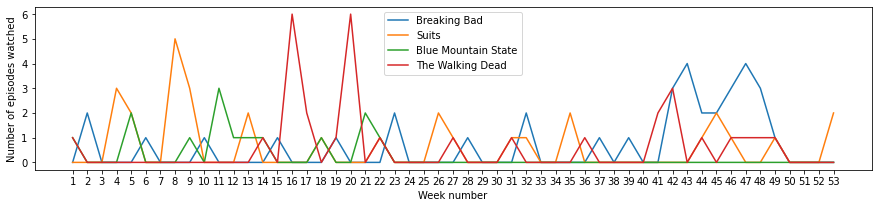

In [11]:
def TV_show_year(netflix_hist, name_TVshow, year):
    A = netflix_hist.index.str.contains( name_TVshow ) 
    res = [i for i, val in enumerate(list(A)) if val]

    tv_show = netflix_hist.iloc[res]
    tv_show = tv_show.drop_duplicates()

    tv_show["week_no"] = 0

    for lab, row in tv_show.iterrows():
        d=row["Date"].strftime("%Y/%m/%d").split('/')
        wkno = date(int(d[0]),int(d[1]),int(d[2])).isocalendar()[1]
        tv_show.loc[lab,"week_no"] = wkno

    tv_show['Date'] = pd.to_datetime( tv_show['Date'] )
    tv_show["Year"] = tv_show["Date"].dt.year

    tv_show = tv_show.loc[ tv_show["Year"] == year]
    summary_tv = tv_show["week_no"].value_counts()

    week_numbers = np.arange(1,54, 1)
    summary_wkno = []

    for x in week_numbers:
        if x in list(summary_tv.index):
            summary_wkno.append(summary_tv.loc[x])
        else: 
            summary_wkno.append(0)
    return summary_wkno

week_numbers = np.arange(1,54, 1)
breaking_bad = TV_show_year(netflix_hist, "Breaking Bad", 2016)
suits = TV_show_year(netflix_hist, "Suits", 2016)
bluemountain = TV_show_year(netflix_hist, "Blue Mountain State", 2016)
walkingdead = TV_show_year(netflix_hist, "The Walking Dead", 2016)

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(week_numbers, breaking_bad, label='Breaking Bad')
ax.plot(week_numbers, suits, label='Suits')
ax.plot(week_numbers, bluemountain, label='Blue Mountain State')
ax.plot(week_numbers, walkingdead, label='The Walking Dead')
plt.legend()
plt.xticks(week_numbers)
plt.ylabel('Number of episodes watched')
plt.xlabel('Week number')
plt.show()

In [12]:
# Before we add average duration for the series
series = netflix_hist[ netflix_hist["is_TV_show"] == True ]
series = series.reset_index()
series["TV_show"] = series["Title"].str.split(':',expand=True)[0]

TV_show_unique = series["TV_show"].unique()

print("Number of TV shows to scrape: {} \n".format(TV_show_unique.shape[0]))

print(TV_show_unique)

Number of TV shows to scrape: 59 

['MINDHUNTER' 'Dark' 'Black Mirror' 'Jeffrey Epstein' 'El último baile'
 'Vikingos' 'Cómo defender a un asesino' 'Gossip Girl'
 'Maradona en Sinaloa' 'Big Mouth' 'Luther' 'Suits' 'Atípico' 'El espía'
 'Sherlock' 'Parte 4 (Tráiler)' 'La casa de papel' 'Last Chance U'
 'Así nos ven' 'Formula 1' 'Élite' 'Hijos de la anarquía' 'El tirador'
 'Paradise Police' 'One-Punch Man' 'Peaky Blinders' 'Yu-Gi-Oh!'
 'Fastest Car' 'Trump' 'El asesinato de Gianni Versace' 'Scorpion' 'Arrow'
 'Ray Donovan' 'BoJack Horseman' 'Californication' 'Flaked'
 'Club de Cuervos' 'Mad Men' 'Prison Break' '1000 maneras de morir'
 'Better Call Saul' 'Breaking Bad' 'Inside the World’s Toughest Prisons'
 'The Last Kingdom' 'El club de la comedia' 'The Walking Dead'
 'Marvel - Luke Cage' 'Crossing Lines' 'Top Gear' 'Pokémon' 'Sin límites'
 'New Girl' 'Miénteme' 'Blue Mountain State' 'Made in Mexico'
 'Marvel - Daredevil' 'The Confession Tapes'
 '¿Dónde se esconden los más buscados?' 'Qu

# Webscraping to get average duration (TV show)

In this part, we will do some Webscraping to get the average duration of an episode for each TV show. The TV shows found are shown above (with a total of 59 TV shows to look for).

The Webscraping is done in Google Search and if a solution cannot be found we will assume that the episode duration for this TV show is 40 minutes. 

In [24]:
def web_scrape (TV_shows, message, default_value):
    p = 0
    for lab, row in TV_shows.iterrows():

        search_item = message + row["TV_show"]
        base = "http://www.google.es"
        url = "http://www.google.es/search?q="+ search_item
        response = requests.get(url)

        soup = BeautifulSoup(response.text,"lxml")
        text = soup.text
        minutes_text_1 = re.findall("..min", text)
        minutes_text_2 = re.findall(".. min", text)
        min = default_value
        
        found = False

        for x in minutes_text_1:
            try:
                number = int(x[0:2])
                if number > 30 and number < 90:
                    min = number
                    if found == False:
                        p = p + 1
                        found = True
            except:
                pass  
        for x in minutes_text_2:
            try:
                number = int(x[0:2])
                if number > 30 and number < 90:
                    min = number
                    if found == False:
                        p = p + 1
                        found = True
            except:
                pass  

        TV_shows.loc[lab, "duration"] = min       
    return(TV_shows, p)

TV_shows = pd.DataFrame(TV_show_unique,columns=["TV_show"])

TV_shows, x1 = web_scrape (TV_shows, "average episode ", -50)
#TV_shows[TV_shows['Duration'] == -50] = web_scrape (TV_shows[TV_shows['Duration'] == -50], "Duracion episodio ", -50)

# We assign an average duration for episode (for those whose information could not be found)
TV_shows[TV_shows['duration'] == -50], x2 = web_scrape (TV_shows[TV_shows['duration'] == -50], "Duracion capitulo", 40)

x = x1+x2 # Number of TV shows with duration found with webscraping

assert len(TV_shows[TV_shows['duration'] == -50]) == 0

print('Web Scraping finished for TV shows')
print('     Out of {} TV shows, the duration for {} was found.'.format((TV_show_unique.shape[0]), x))

Web Scraping finished for TV shows
     Out of 59 TV shows, the duration for 40 was found.


## Most watched TV shows 

The plots below show the 20 most watched TV shows with the duration in hours for each of them and the 11 most watched TV shows in a pie chart with a percentage of the hours spent watching TV shows.

In [25]:
# We join information from TV_show with their duration and series dataframe
series_with_duration = pd.merge(series[["Title","Date","is_TV_show","TV_show"]], TV_shows, on="TV_show")
print(series_with_duration.head())

# Check if a row has missing information
series_with_duration.isna().sum()

                                 Title       Date  is_TV_show     TV_show  \
0  MINDHUNTER: Temporada 2: Episodio 9 2020-01-08        True  MINDHUNTER   
1  MINDHUNTER: Temporada 2: Episodio 8 2020-07-31        True  MINDHUNTER   
2  MINDHUNTER: Temporada 2: Episodio 7 2020-07-31        True  MINDHUNTER   
3  MINDHUNTER: Temporada 2: Episodio 6 2020-07-31        True  MINDHUNTER   
4  MINDHUNTER: Temporada 2: Episodio 5 2020-07-31        True  MINDHUNTER   

   duration  
0      60.0  
1      60.0  
2      60.0  
3      60.0  
4      60.0  


Title         0
Date          0
is_TV_show    0
TV_show       0
duration      0
dtype: int64

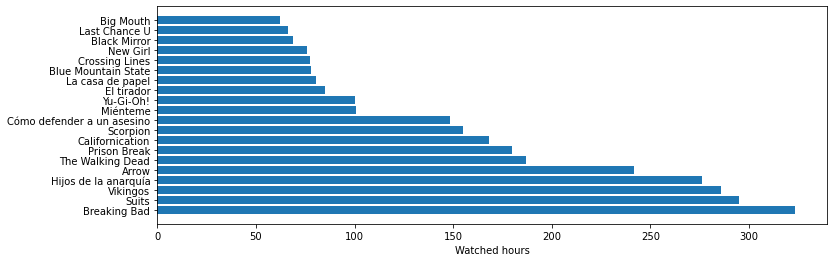

In [26]:
TVshow_groupby = series_with_duration.groupby(by='TV_show').sum()

TVshow_groupby = TVshow_groupby.sort_values('duration', ascending=False) 
TVshow_groupby['duration_hours'] = TVshow_groupby['duration']/60

fig, ax = plt.subplots(figsize=(12,4))
most_watched = TVshow_groupby.head(20)
plt.barh(most_watched.index, most_watched['duration_hours'])
plt.xlabel('Watched hours')
plt.show()

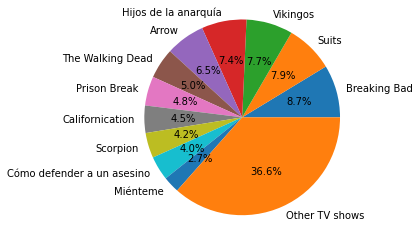

In [27]:
TVshow_groupby = series_with_duration.groupby(by='TV_show').sum()

TVshow_groupby = TVshow_groupby.sort_values('duration', ascending=False) 

total_duration = TVshow_groupby['duration'].sum()
most_watched_and_others = TVshow_groupby.head(11) 
most_watched_duration = most_watched_and_others['duration'].sum()

most_watched_and_others['size'] = most_watched_and_others['duration'] / total_duration

others = pd.DataFrame({"is_TV_show":1.0, "duration":total_duration-most_watched_duration, "size":(total_duration-most_watched_duration)/total_duration}, index = ["Other TV shows"])

most_watched_and_others = most_watched_and_others.append( others )

most_watched_and_others = most_watched_and_others["size"]

labels = most_watched_and_others.index

fig1, ax1 = plt.subplots()
ax1.pie(most_watched_and_others, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=0)
ax1.axis('equal')

plt.show()

We join the information obtained from TV shows to the whole dataframe. To do so, a for loop has been used matching each episode in the series_with_duration dataframe with the Title. Could I avoid using the for loop and implement something more direct?  

And we also prepare the data for a webscraping for the duration in this case of each film (or better to be said for each instance in the dataframe that was considered to be a TV show). 

In [28]:
netflix_hist = netflix_hist.reset_index() 

for lab, row in series_with_duration.iterrows():
    title = row["Title"]
    duration = row["duration"]
    netflix_hist.loc[ netflix_hist["Title"] == title, "duration"] = duration
    
print(netflix_hist["duration"].describe())

count    5412.000000
mean       35.687361
std        31.066513
min       -50.000000
25%        40.000000
50%        44.000000
75%        47.000000
max        75.000000
Name: duration, dtype: float64


In [29]:
netflix_hist.loc[netflix_hist["duration"].isnull(), "duration"] = -50

print("Number of films to scrape: {}".format(netflix_hist.loc[netflix_hist["duration"]== -50].shape[0]))

films_sample = netflix_hist.loc[netflix_hist["duration"]== -50][0:100]
#films_sample = films_sample.drop_duplicates()

films_sample.head(10)

Number of films to scrape: 603


,index,Title,Date,is_TV_show,duration
0,0,El practicante,2020-09-17,False,-50.0
1,1,El Hombre de las Mil Caras,2020-01-08,False,-50.0
2,2,Hitting the Apex,2020-02-07,False,-50.0
3,3,Sigue el ritmo,2020-06-30,False,-50.0
4,4,La Red Avispa,2020-06-23,False,-50.0
37,37,La noche más oscura (Zero Dark Thirty),2019-07-21,False,-50.0
38,38,Black Mirror: Bandersnatch,2020-10-06,False,-50.0
133,133,Senna,2019-12-19,False,-50.0
199,199,El caballero oscuro: La leyenda renace,2019-11-29,False,-50.0
200,200,El caballero oscuro,2019-11-24,False,-50.0


# Web scraping to get duration (films) 

As we have 603 films, the webscraping for all of them takes so much time, so instead we will only take a sample and assign a default value of 100 min for the ones where a solution could not be found or for the ones we didn't web scrape.

Only 100 films will be webscrapped, to do all the films a more efficient way to webscraping could be developed in order to decrease the computational time. 

Finally, we join the information with the whole dataframe. 

In [23]:
def web_scrape (films, message, default_value):
    p = 0
    for lab, row in films.iterrows():

        search_item = message + row["Title"]
        base = "http://www.google.es"
        url = "http://www.google.es/search?q="+ search_item
        response = requests.get(url)

        soup = BeautifulSoup(response.text,"lxml")
        text = soup.text

        hours_min_text_1 = re.findall(".h .m", text)
        hours_min_text_2 = re.findall(".h ..m", text)

        minutes_text_1 = re.findall("..min", text)
        minutes_text_2 = re.findall("...min", text)

        min = default_value
        found = False

        # Hour and 1-digit minutes
        for x in hours_min_text_1:
            #print(x)
            try:
                hour = int(x[0:1])
                minutes = int(x[3:4])
                min = hour*60 + minutes
                if found == False:
                    p = p+1
                    found = True
            except:
                pass  

        # Hour and 2-digit minutes
        for x in hours_min_text_2:
            #print(x)
            try:
                hour = int(x[0:1])
                minutes = int(x[3:5])
                min = hour*60 + minutes
                if found == False:
                    p = p+1
                    found = True
            except:
                pass  

        # 2-digit minutes
        for x in minutes_text_1:
            #print(x)
            try:
                number = int(x[0:2])
                if number > 30 and number < 100:
                    min = number
                    if found == False:
                        p = p+1
                        found = True
            except:
                pass  

        # 3-digit minutes
        for x in minutes_text_2:
            #print(x)
            try:
                number = int(x[0:3])
                if number > 30 and number < 200:
                    min = number
                    if found == False:
                        p = p+1
                        found = True
            except:
                pass  

        films.loc[lab, "duration"] = min       
    return(films, p)

films_sample, x = web_scrape (films_sample, "Duracion pelicula ", 100)

assert len(films_sample[films_sample['duration'] == -50]) == 0

print('Web Scraping finished for films')
print('     Out of {} films, the duration for {} was found.'.format(films_sample.shape[0], x))

Web Scraping finished for films
     Out of 100 films, the duration for 100 was found.


In [30]:
for lab, row in films_sample.iterrows():
    title = row["Title"]
    duration = row["duration"]
    netflix_hist.loc[ netflix_hist["Title"] == title, "duration"] = duration

netflix_hist.loc[netflix_hist["duration"] == -50, "duration"] = 100    
print(netflix_hist["duration"].describe())

count    5412.000000
mean       52.400222
std        18.123415
min        37.000000
25%        42.000000
50%        44.000000
75%        55.000000
max       100.000000
Name: duration, dtype: float64


# Comparison between TV shows and films

A comparison between the number of episodes and films is carried out. 

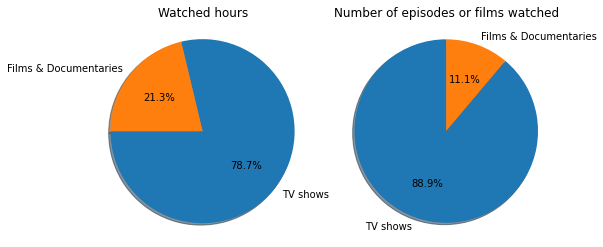

In [31]:
TV_show_vs_films = netflix_hist.groupby("is_TV_show").sum()
TV_show_vs_films = TV_show_vs_films["duration"]
TV_show_vs_films = TV_show_vs_films.sort_values(ascending=False)
size_TV_show_vs_films = TV_show_vs_films / TV_show_vs_films.sum()

count_TV_show_vs_films = netflix_hist["is_TV_show"].value_counts()

labels = ["TV shows", "Films & Documentaries"]

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].pie(size_TV_show_vs_films, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax[0].axis('equal')
ax[0].set_title('Watched hours')

ax[1].pie(count_TV_show_vs_films, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal')
ax[1].set_title('Number of episodes or films watched')

plt.show()

# Viewing History

In the first plot below, you can see the evolution across each month in every year of my Netflix viewing history. It seems that my consumption has decreased each year. 

This first plot answers the question: Has my consumption decreased?

On the other hand, in the second plot plot below, note that most of the watched hours during the first years were mostly coming from TV shows and that my consumption now comes mostly from films and TV shows. 

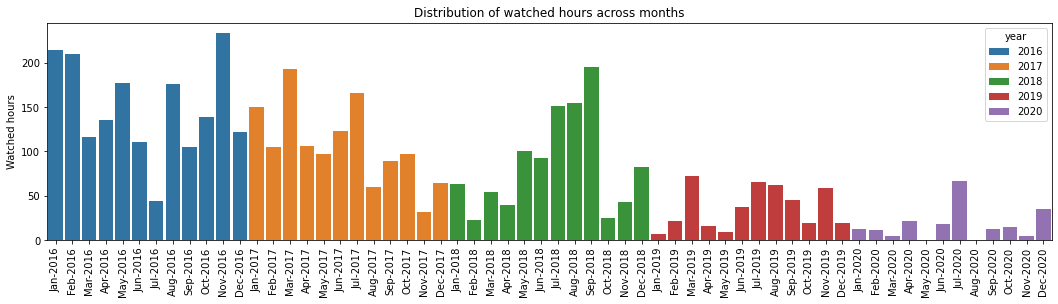

In [32]:
netflix_hist["month"] = netflix_hist["Date"].dt.month
netflix_hist["year"] = netflix_hist["Date"].dt.year
netflix_hist["weekday"] = netflix_hist["Date"].dt.weekday
month_year_groupby = netflix_hist.groupby(by=['month','year']).sum()

month_year_groupby['duration_hours'] = month_year_groupby['duration'] / 60

month_year_groupby = month_year_groupby.reset_index(level=['month','year'])

for year in month_year_groupby["year"].unique():
    for month in np.arange(1,13):
        months_list = list(month_year_groupby.loc[month_year_groupby["year"]==year]["month"])
        bool_m = month in months_list
        if bool_m == False:
            month_year_groupby = month_year_groupby.append( {"month":int(month), "year":int(year), "is_TV_show":0, "duration":0, "duration_hours":0}, ignore_index = True)

month_year_groupby["year"] = month_year_groupby["year"].astype("int")

month_names = pd.DataFrame([[1,"Jan"],[2,"Feb"],[3,"Mar"],[4,"Apr"],[5,"May"],[6,"Jun"],[7,"Jul"],[8,"Aug"],[9,"Sep"],[10,"Oct"],[11,"Nov"],[12,"Dec"]], columns=['month','month_name'])

month_year_groupby = pd.merge(month_year_groupby, month_names, on='month')
month_year_groupby['month-year'] = ["{}-{}".format(m, y) for m, y in zip(month_year_groupby['month_name'], month_year_groupby['year'])]

month_year_groupby = month_year_groupby.sort_values(['year','month'])

fig, ax = plt.subplots(figsize=(18,4))
_ = sns.barplot(x='month-year', y='duration_hours', ax = ax, hue='year', data=month_year_groupby, dodge=False)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(_, .87)

plt.xticks(rotation='vertical')
plt.ylabel('Watched hours')
plt.title('Distribution of watched hours across months')
plt.xlabel('')
plt.show()

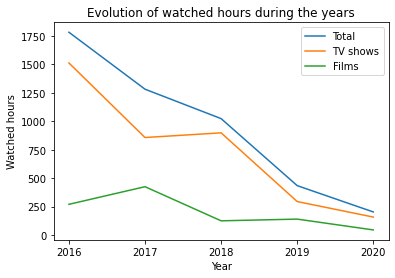

In [33]:
year_groupby = month_year_groupby.groupby(by=['year']).sum()
year_groupby.reset_index()

year_type_groupby = netflix_hist.groupby(by=['year','is_TV_show']).sum()
year_type_groupby['duration_hours'] = year_type_groupby['duration'] / 60
year_type_groupby = year_type_groupby.reset_index()
year_TV_show = year_type_groupby[ year_type_groupby["is_TV_show"] == True]
year_film = year_type_groupby[ year_type_groupby["is_TV_show"] == False]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(year_groupby.index, year_groupby["duration_hours"], label='Total')
ax.plot(year_groupby.index, year_TV_show["duration_hours"], label='TV shows')
ax.plot(year_groupby.index, year_film["duration_hours"], label='Films')
plt.legend()
plt.xticks(year_groupby.index)
plt.ylabel('Watched hours')
plt.xlabel('Year')
plt.title('Evolution of watched hours during the years')
plt.show()

# Monthly and daily comparisons

In the first plot below, we can see the number of hours watching Netflix for each month. Note that these values are the sum across the years. January is the month with more watched hours probably because of the boom in the first year (when I discovered Netflix).

This plot answers the question: Which month do I spend more time on Netflix?

In the second plot, a similar plot is obtained in this case for each day of the week. It is interesting to see that I tend to watch more films at the weekend and that my consumption is greater at the weekend comparing to midweek, as someone would expect.

This plot answers the question: Which day of the week do I watch more Netflix?

It is interesting to see these plots and it makes me wander. Why October is the month with less watched hours? Probably because partial exams at the winter semester at University when I am more focused on getting good marks this year. 

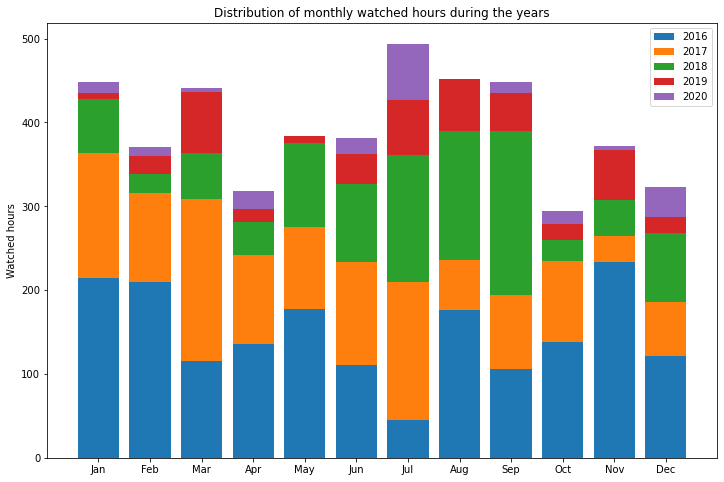

In [34]:
month_years_pt = month_year_groupby.pivot_table( values="duration_hours", index = "month_name",                                                                                     columns = "year", aggfunc = sum, fill_value = 0)

month_years_pt = month_years_pt.loc[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]

fig, ax = plt.subplots(figsize=(12,8))

ax.bar( month_years_pt.index, month_years_pt[2016], label="2016" )
ax.bar( month_years_pt.index, month_years_pt[2017], bottom = month_years_pt[2016], label = "2017" )
ax.bar( month_years_pt.index, month_years_pt[2018],
bottom = month_years_pt[2016] + month_years_pt[2017], label = "2018" )
ax.bar( month_years_pt.index, month_years_pt[2019],
bottom = month_years_pt[2016] + month_years_pt[2017] + month_years_pt[2018], label = "2019" )
ax.bar( month_years_pt.index, month_years_pt[2020],
bottom = month_years_pt[2016] + month_years_pt[2017] + month_years_pt[2018] + month_years_pt[2019], label = "2020" )
ax.set_xticklabels( month_years_pt.index) 
ax.set_ylabel("Watched hours")
plt.title('Distribution of monthly watched hours during the years')
ax.legend()
plt.show()

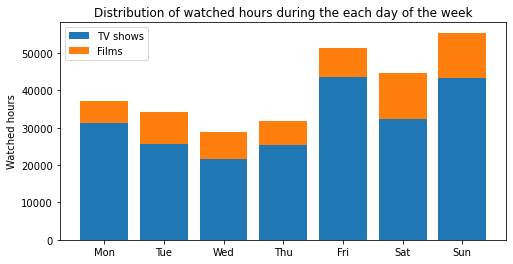

In [35]:
weekday_value_counts = netflix_hist["weekday"].value_counts()
weekday_groupby = netflix_hist.groupby(by=['weekday','is_TV_show']).sum()

weekday_groupby = weekday_groupby.reset_index()

weekday_TV_shows = weekday_groupby[weekday_groupby["is_TV_show"] == True]
weekday_films = weekday_groupby[weekday_groupby["is_TV_show"] == False]

weekday_names =["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, ax = plt.subplots(figsize=(8,4))

ax.bar( weekday_names, weekday_TV_shows["duration"], label="TV shows" )
ax.bar( weekday_names, weekday_films["duration"], bottom = weekday_TV_shows["duration"], label = "Films" )
ax.set_ylabel("Watched hours")
plt.title('Distribution of watched hours during the each day of the week')
ax.legend()
plt.show()

In [36]:
print("Watched hours: {:.2f}".format(netflix_hist["duration"].sum()/60))
print("Watched days: {:.2f}".format(netflix_hist["duration"].sum()/60/24))
print("Watched months: {:.2f}".format(netflix_hist["duration"].sum()/60/24/30))

print("% of time spent in 5 years: {:.2f}".format(netflix_hist["duration"].sum()/60/24/30 / (12*5) * 100))

Watched hours: 4726.50
Watched days: 196.94
Watched months: 6.56
% of time spent in 5 years: 10.94


# Conclusions

All in all, the results achieved are satisfactory and even though some of them were as expected, it is interesting to see the real numbers and the insights this data provides.  It is suprising to see the amount of hours spent watching films that translate to the crazy amount 6 months of time (of my life). Even though, it is onlt 10.94% of my time during these years.

I have to say that didn't end all of the episodes and films I watched. However, I also have to admit that this is only on Netflix, and I also have watched series and films in Amazon Prime and some in HBO as wella as watched many Youtube Videos. So the results here made me conscious about the actual time spent on entertainment. 

# Next Steps 

The next steps can be:
* Create a website with Flask (for example) so anyone can enter their Netflix Viewing History and see their viewing stats. (on my to-do list)

* Improve the web scraping function in order to be less time consuming.

* Make a recommendation engine using your information and getting other titles information from Netflix API or databases/datasets. 
